In [25]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import google.generativeai as genai
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

# --- 1. API Key and Custom Embedding Model (No changes) ---
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

class GeminiEmbeddingModel:
    def __init__(self, model_name="models/text-embedding-004"):
        self.model_name = model_name
    def embed(self, documents, verbose=False):
        if verbose: print(f"Requesting embeddings for {len(documents)} documents from API...")
        try:
            result = genai.embed_content(model=self.model_name, content=documents, task_type="RETRIEVAL_DOCUMENT")
            if verbose: print("Embeddings received.")
            return np.array(result['embedding'])
        except Exception as e:
            print(f"An error occurred during embedding: {e}")
            return np.empty((0, 768))

print("Custom GeminiEmbeddingModel class defined.")


# --- 2. Corrected Dummy Models (Final Version for ALL components) ---

# This model is for UMAP (dimensionality reduction)
class PassThroughModel:
    """A dummy model that has both .fit and .transform methods."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

# --- THIS IS THE KEY CORRECTION for this error ---
# This model is for HDBSCAN (clustering). It now has a .fit method
# and creates the necessary .labels_ attribute that BERTopic looks for.
class DummyClusteringModel:
    """A dummy clustering model that mimics HDBSCAN."""
    def __init__(self):
        # BERTopic checks for this attribute after fitting
        self.labels_ = None
    
    def fit(self, X, y=None):
        """Creates dummy .labels_ attribute."""
        print("Bypassing clustering with DummyClusteringModel...")
        self.labels_ = np.array([-1] * len(X)) # Assign every document to topic -1 (outlier)
        return self

print("Fully compliant dummy models defined.")


# --- 3. Load Data and Define Categories (No changes) ---
csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/MPE_dataset_translated_batched.csv'
df = pd.read_csv(csv_path)
df.dropna(subset=['phen_report_english'], inplace=True)
df = df[df.phen_report_english.str.strip() != '']

reports = df['phen_report_english'].tolist()
print(f"Loaded {len(reports)} documents.")

reports_sentences = [nltk.sent_tokenize(report) for report in reports]
sentences = [sentence for report in reports_sentences for sentence in report]

min_word_count = 2
sentences = [s for s in sentences if len(s.split()) > min_word_count]
docs = sentences

mpe_factors = [
    "Time, Effort and Desire", "Peace, Bliss and Silence", "Self-Knowledge, Autonomous Cognizance and Insight",
    "Wakeful Presence", "Pure Awareness in Dream and Sleep", "Luminosity", "Thoughts and Feelings",
    "Emptiness and Non-egoic Self-awareness", "Sensory Perception in Body and Space",
    "Touching World and Self", "Mental Agency", "Witness Consciousness"
]
print(f"Loaded {len(docs)} documents and {len(mpe_factors)} categories.")


# --- 4. Instantiate and Run the Full Pipeline ---
print("\nInstantiating models with API and fully compliant dummy components...")

api_embedding_model = GeminiEmbeddingModel()
dummy_dim_reduction_model = PassThroughModel()
dummy_cluster_model = DummyClusteringModel() # Using the new fully compliant clustering model
dummy_vectorizer = CountVectorizer(stop_words="english")

topic_model = BERTopic(
  embedding_model=api_embedding_model,
  umap_model=dummy_dim_reduction_model,
  hdbscan_model=dummy_cluster_model,
  vectorizer_model=dummy_vectorizer,
  zeroshot_topic_list=mpe_factors,
  zeroshot_min_similarity=0.5,
  verbose=True
)

# Call .fit_transform()
print("\nStarting zero-shot classification with .fit_transform()...")
topics, probs = topic_model.fit_transform(docs)

print("\nClassification complete!")


sentences_df = pd.DataFrame({"sentence": docs})

# Add the topic ID and topic name to this new DataFrame.
sentences_df['topic_id'] = topics
sentences_df['topic_name'] = [mpe_factors[topic_id] if topic_id != -1 else "Unclassified" for topic_id in topics]

print("Classification complete! Showing results for each sentence:")
# Display the first 10 sentences and their assigned topics
display(sentences_df.head(10))

# The topic distribution table from get_topic_info() is already based on sentences, so it's correct.
print("\nTopic Distribution (based on sentences):")
display(topic_model.get_topic_info())

Custom GeminiEmbeddingModel class defined.
Fully compliant dummy models defined.
Loaded 830 documents.


2025-06-29 19:43:29,525 - BERTopic - Embedding - Transforming documents to embeddings.


Loaded 5920 documents and 12 categories.

Instantiating models with API and fully compliant dummy components...

Starting zero-shot classification with .fit_transform()...


Batches:   0%|          | 0/185 [00:00<?, ?it/s]

2025-06-29 19:43:44,429 - BERTopic - Embedding - Completed ✓
2025-06-29 19:43:44,430 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 19:43:44,430 - BERTopic - Dimensionality - Completed ✓
2025-06-29 19:43:44,437 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-29 19:43:44,565 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-06-29 19:43:44,581 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 19:43:44,600 - BERTopic - Cluster - Completed ✓
2025-06-29 19:43:44,613 - BERTopic - Zeroshot Step 2 - Combining topics from zero-shot topic modeling with topics from clustering...
2025-06-29 19:43:44,628 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-29 19:43:44,629 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-29 19:43:44,697 - BERTopic - Representation - Completed ✓


Bypassing clustering with DummyClusteringModel...

Classification complete!
Classification complete! Showing results for each sentence:


,sentence,topic_id,topic_name
0,"Pure awareness, for me, is an all-pervasive st...",4,Pure Awareness in Dream and Sleep
1,It has to do with a rhythm linked to breathing...,-1,Unclassified
2,It is muffled and sharp at the same time.,-1,Unclassified
3,My first experience that would fit your descri...,10,Mental Agency
4,Due to the death of my mother (when I was seve...,-1,Unclassified
5,"One day, the following question arose in my mi...",-1,Unclassified
6,Who is thinking here?,-1,Unclassified
7,"Who am I?""",-1,Unclassified
8,"At that moment, I felt for the first time that...",6,Thoughts and Feelings
9,I felt like a lonely spectator in an empty cin...,-1,Unclassified



Topic Distribution (based on sentences):


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4792,-1_experience_meditation_time_like,"[experience, meditation, time, like, state, fe...","[While meditating, I felt a complete detachmen..."
1,0,6,"Time, Effort and Desire","[effortless, fulfillment, desire, naturalness,...","[There was no effort, a feeling of great natur..."
2,1,130,"Peace, Bliss and Silence","[peace, deep, bliss, silence, peaceful, feelin...","[Deep peace, bliss, I can do no more—so I have..."
3,2,7,"Self-Knowledge, Autonomous Cognizance and Insight","[insight, standard, knowledge, understanding, ...",[The complete insight/realization that all kno...
4,3,61,Wakeful Presence,"[presence, wakefulness, awake, waking, wakeful...","[A moment of total presence., I am in a state ..."
5,4,275,Pure Awareness in Dream and Sleep,"[awareness, pure, dream, sleep, lucid, experie...",[I have experienced the state of pure awarenes...
6,5,5,Luminosity,"[luminosity, calm, easiest, highlight, realise...","[Brightness, density, and utter calm., I reali..."
7,6,147,Thoughts and Feelings,"[thoughts, feeling, feelings, thinking, emotio...",[Then I had a feeling of greater awareness in ...
8,7,193,Emptiness and Non-egoic Self-awareness,"[awareness, emptiness, self, pure, experience,...","[There is only awareness that I am., When I go..."
9,8,138,Sensory Perception in Body and Space,"[body, sensations, perception, sensory, space,...","[For me, this space was an object of my consci..."


In [26]:
# --- 5. Process and Analyze Results (Definitive Version) ---

# First, get the topic information DataFrame from the model. This is our "source of truth".
topic_info_df = topic_model.get_topic_info()

# Create a mapping dictionary from Topic ID to the correct Name
# e.g., {0: 'Peace, Bliss and Silence', 10: 'Witness Consciousness', ...}
topic_id_to_name_map = topic_info_df.set_index('Topic')['Name'].to_dict()


# Now, create the sentences DataFrame
sentences_df = pd.DataFrame({"sentence": docs})
sentences_df['topic_id'] = topics # The list of IDs from the model [0, 4, 10, -1, ...]

# Use the .map() function with our correct dictionary to create the topic_name column
# .fillna() handles the -1 (outlier) case cleanly.
sentences_df['topic_name'] = sentences_df['topic_id'].map(topic_id_to_name_map).fillna("Unclassified")


# --- The Analysis Loop (This part is now correct because sentences_df is correct) ---

print("--- Analysis of Sentences per Topic Category ---")

# Loop through each ROW of the topic_info_df results DataFrame
for index, row in topic_info_df[topic_info_df.Topic != -1].iterrows():
    
    # Get the topic name and the correct count directly from the results table
    topic_name = row['Name']
    count = row['Count']
    
    print("="*50)
    print(f"Topic: {topic_name}")
    print("="*50)
    print(f"Number of sentences: {count}\n")

    # Filter the now-correctly-labeled sentences_df
    topic_specific_df = sentences_df[sentences_df['topic_name'] == topic_name]
    
    # Display up to 10 representative sentences
    if not topic_specific_df.empty:
        print("Representative Sentences:")
        representative_sentences = topic_specific_df['sentence'].head(10)
        for i, sentence in enumerate(representative_sentences):
            print(f"  {i+1}. {sentence.lstrip()}")
    else:
        print("No sentences were classified under this topic.")
        
    print("\n")

--- Analysis of Sentences per Topic Category ---
Topic: Time, Effort and Desire
Number of sentences: 6

Representative Sentences:
  1. The experience was one of effortlessness, and without any noticeable sense of desire.
  2. Active, connected, timeless, effortless, self-evident.
  3. From this, a state of total lack of desire, fulfillment beyond fulfillment, incredible inner peace, which may remain for a long time, quickly arises.
  4. There was no effort, a feeling of great naturalness and well-being, as if I were experiencing the actual, original quality of the mind.
  5. It was effortless.
  6. It was effortless, blissful, always now, moment to moment.


Topic: Peace, Bliss and Silence
Number of sentences: 130

Representative Sentences:
  1. There is great peace, boundless space, and clarity.
  2. A feeling of deep peace, of both being the entire limitless space of awareness and being in the entire limitless space of awareness at the same time.
  3. The experience is always connect

Generating visualization...

Visualization complete! The chart has been saved as 'topic_distribution.png'.


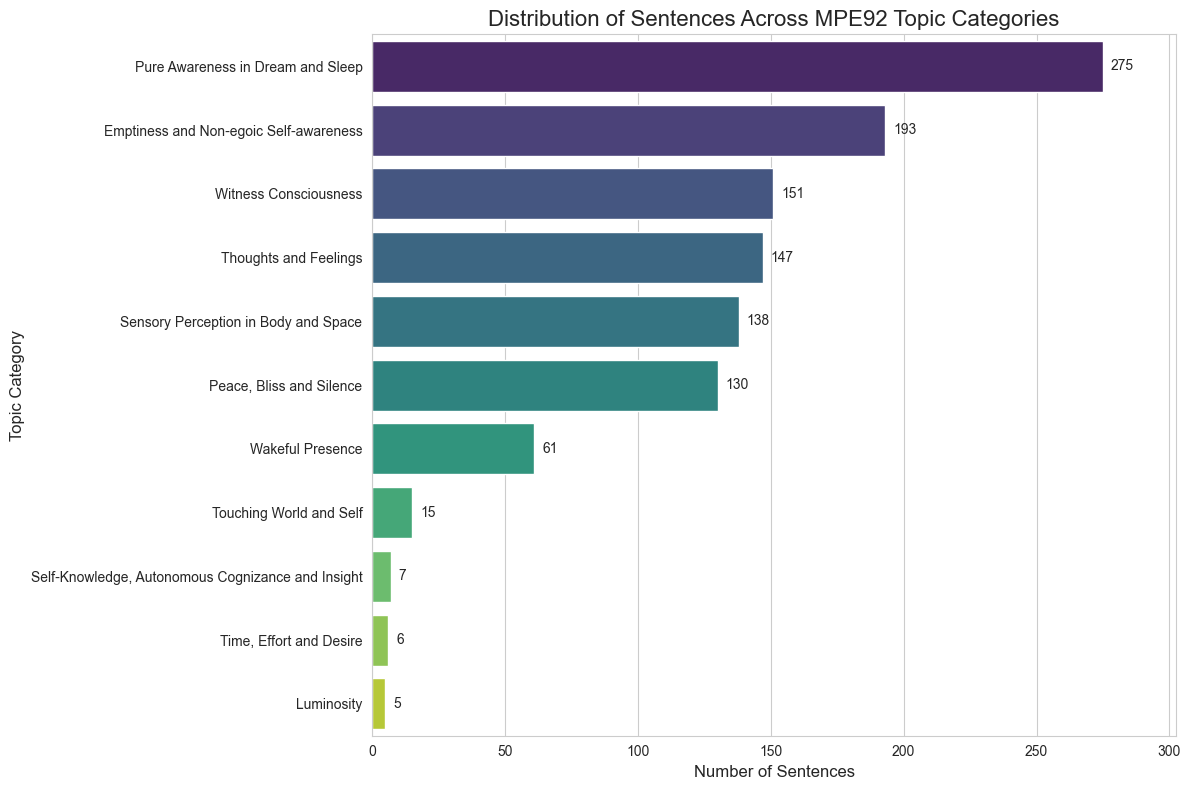

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have the 'topic_info_df' DataFrame from the previous step.
print("Generating visualization...")

# --- 1. Prepare the Data for Plotting ---

# Filter out the "Unclassified" topic (Topic ID -1) as it's not a real category
plot_df = topic_info_df[topic_info_df.Topic != -1].copy()

# Sort the topics by count, from highest to lowest
plot_df = plot_df.sort_values("Count", ascending=False)


# --- 2. Create the Plot ---

# Set a nice style for the plot
sns.set_style("whitegrid")

# Create a figure and axes to control the plot size
# A larger height helps accommodate all the topic labels
plt.figure(figsize=(12, 8))

# Create the horizontal bar plot
ax = sns.barplot(x='Count', y='Name', data=plot_df, palette='viridis', orient='h')


# --- 3. Add Data Labels and Final Touches ---

# Add the exact count at the end of each bar for clarity
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3,  # Position the text slightly to the right of the bar
            p.get_y() + p.get_height() / 2., # Center the text vertically on the bar
            f'{int(width)}', # The text to display (the count)
            ha='left', 
            va='center')

# Set titles and labels for clarity
ax.set_title('Distribution of Sentences Across MPE92 Topic Categories', fontsize=16)
ax.set_xlabel('Number of Sentences', fontsize=12)
ax.set_ylabel('Topic Category', fontsize=12)

# Adjust the x-axis limit to give space for the data labels
ax.set_xlim(0, plot_df['Count'].max() * 1.1) 

# Ensure everything fits nicely
plt.tight_layout()

# Save the plot to a file
# You can now download this PNG and use it in your presentation
plt.savefig("topic_distribution.png", dpi=300)

print("\nVisualization complete! The chart has been saved as 'topic_distribution.png'.")

In [29]:
import pandas as pd
from IPython.display import display, HTML

# Ensure you have the 'topic_info_df' and 'sentences_df' DataFrames from the previous steps.

# This list will hold the data for our new summary table
summary_data = []

# Filter out the "Unclassified" topic and sort by the original topic ID
# Sorting by 'Topic' makes the output order match the summary table you saw.
topics_to_show = topic_info_df[topic_info_df.Topic != -1].sort_values(by="Topic")


# Loop through each classified topic from the results
for index, row in topics_to_show.iterrows():
    topic_name = row['Name']
    
    # Filter the main sentences DataFrame for the current topic
    topic_specific_df = sentences_df[sentences_df['topic_name'] == topic_name]
    
    # Safely get the first representative sentence
    if len(topic_specific_df) > 0:
        sentence1 = topic_specific_df['sentence'].iloc[0]
    else:
        sentence1 = "No sentences found."
        
    # Safely get the second representative sentence
    if len(topic_specific_df) > 1:
        sentence2 = topic_specific_df['sentence'].iloc[1]
    else:
        sentence2 = "N/A" # Use N/A if there's only one sentence
        
    # Add the data for this topic to our list
    summary_data.append({
        "Topic Category": topic_name,
        "Representative Sentence 1": sentence1,
        "Representative Sentence 2": sentence2
    })

# Create the final summary DataFrame
summary_df = pd.DataFrame(summary_data)

# --- Display the final table ---
print("--- Representative Sentences per Topic Category (for Presentation) ---")

# Use Pandas styling for a cleaner look and to handle long text wrapping
# This makes the table much more readable and presentable
html = summary_df.to_html(index=False)
display(HTML(html))

--- Representative Sentences per Topic Category (for Presentation) ---


Topic Category,Representative Sentence 1,Representative Sentence 2
"Time, Effort and Desire","The experience was one of effortlessness, and without any noticeable sense of desire.","Active, connected, timeless, effortless, self-evident."
"Peace, Bliss and Silence","There is great peace, boundless space, and clarity.","A feeling of deep peace, of both being the entire limitless space of awareness and being in the entire limitless space of awareness at the same time."
"Self-Knowledge, Autonomous Cognizance and Insight","A presence in a broader sense, a knowledge that draws from another essence...","Accordingly, I tried not only to liquidate ""myself"" mentally, but also absolutely everything I had learned, heard, internalized in terms of intellectual role models, and what was dear to me."
Wakeful Presence,"Wakefulness was combined with clarity; everything was harmonious, just as it was.","Otherwise awake, very awake, even."
Pure Awareness in Dream and Sleep,"Pure awareness, for me, is an all-pervasive state where the boundary between myself and the surrounding reality merges, while both my body and reality remain clear.",I experienced pure awareness during a meditation session.
Luminosity,"Even now as I write this, I realize that I am struggling to describe it well; what comes easiest to me is to highlight a vibrant but non-tactile quality and a kind of luminosity in the dark.",Everything is suddenly brighter.
Thoughts and Feelings,"At that moment, I felt for the first time that I am not my thoughts, but the invisible thinker.","I felt a realization of all things I had done, by perceiving objectively the effect of my actions on others as if I had affected not them, but myself, both in terms of the good and the bad I had done."
Emptiness and Non-egoic Self-awareness,Pure awareness is the realization of finally having found home after an eternal search.,"Dissolution of time, space, mind, and the self (individuality)."
Sensory Perception in Body and Space,The state of observing one's own experience from the perspective of pure space.,"I did perceive these sensations, but quickly let them go."
Touching World and Self,"I am aware that there's no boundary separating me from the world, which is to say the world is experiencing itself here.","I would describe it better as a more immediate contact than usual with the world (i.e., less mediated in terms of conceptual processing), with less ""temporal delay,"" more ""inclusive"" (a feeling of expansion of peripersonal space to the point of blurring the distinction between self/non-self, but more like a loss of importance of the self), and above all with a physical-mental feeling of vibrant presence more than usual."


In [30]:
import pandas as pd
from IPython.display import display, HTML

# This assumes 'summary_df' was created in the previous step.
# If not, you can recreate it with the code from the last response.

print("--- Presentation-Ready Summary Table ---")

# Apply styling to the DataFrame
styled_df = summary_df.style.set_properties(**{
    'text-align': 'left',
    'vertical-align': 'top',
    'border': '1px solid #ccc'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold')]},
    {'selector': 'td, th', 'props': [('padding', '10px')]}
]).hide(axis="index")

# Display the styled table in the notebook
display(styled_df)

# You can now take a clean screenshot of this table for your presentation.

--- Presentation-Ready Summary Table ---


Topic Category,Representative Sentence 1,Representative Sentence 2
"Time, Effort and Desire","The experience was one of effortlessness, and without any noticeable sense of desire.","Active, connected, timeless, effortless, self-evident."
"Peace, Bliss and Silence","There is great peace, boundless space, and clarity.","A feeling of deep peace, of both being the entire limitless space of awareness and being in the entire limitless space of awareness at the same time."
"Self-Knowledge, Autonomous Cognizance and Insight","A presence in a broader sense, a knowledge that draws from another essence...","Accordingly, I tried not only to liquidate ""myself"" mentally, but also absolutely everything I had learned, heard, internalized in terms of intellectual role models, and what was dear to me."
Wakeful Presence,"Wakefulness was combined with clarity; everything was harmonious, just as it was.","Otherwise awake, very awake, even."
Pure Awareness in Dream and Sleep,"Pure awareness, for me, is an all-pervasive state where the boundary between myself and the surrounding reality merges, while both my body and reality remain clear.",I experienced pure awareness during a meditation session.
Luminosity,"Even now as I write this, I realize that I am struggling to describe it well; what comes easiest to me is to highlight a vibrant but non-tactile quality and a kind of luminosity in the dark.",Everything is suddenly brighter.
Thoughts and Feelings,"At that moment, I felt for the first time that I am not my thoughts, but the invisible thinker.","I felt a realization of all things I had done, by perceiving objectively the effect of my actions on others as if I had affected not them, but myself, both in terms of the good and the bad I had done."
Emptiness and Non-egoic Self-awareness,Pure awareness is the realization of finally having found home after an eternal search.,"Dissolution of time, space, mind, and the self (individuality)."
Sensory Perception in Body and Space,The state of observing one's own experience from the perspective of pure space.,"I did perceive these sensations, but quickly let them go."
Touching World and Self,"I am aware that there's no boundary separating me from the world, which is to say the world is experiencing itself here.","I would describe it better as a more immediate contact than usual with the world (i.e., less mediated in terms of conceptual processing), with less ""temporal delay,"" more ""inclusive"" (a feeling of expansion of peripersonal space to the point of blurring the distinction between self/non-self, but more like a loss of importance of the self), and above all with a physical-mental feeling of vibrant presence more than usual."


Visualization complete! The summary has been saved as 'topic_sentences_summary.png'.


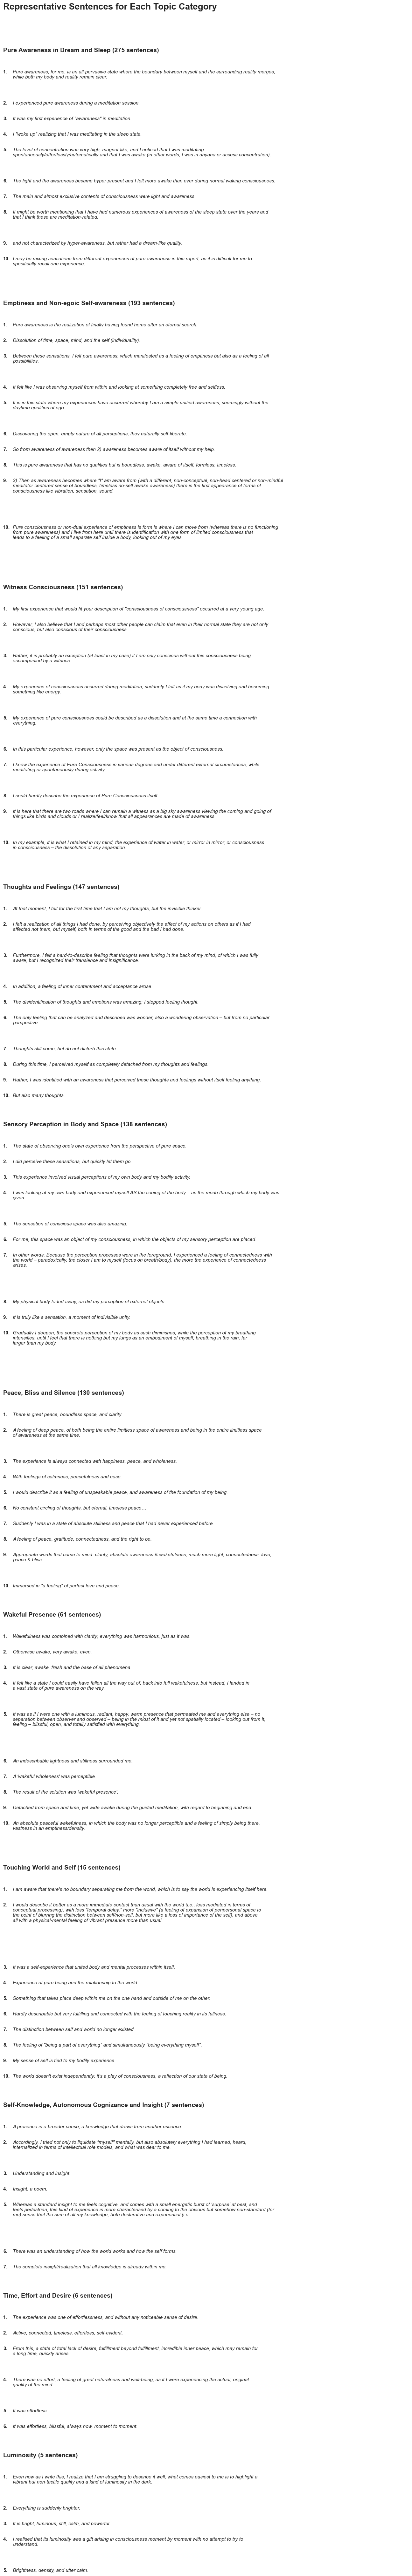

In [31]:
import matplotlib.pyplot as plt
import textwrap

# Ensure you have the 'topic_info_df' and 'sentences_df' DataFrames.

# --- 1. Prepare the Data ---
# Filter out the "Unclassified" topic and sort by count
plot_data = topic_info_df[topic_info_df.Topic != -1].sort_values("Count", ascending=False)

# --- 2. Create the Visualization ---
# Define the figure size based on the number of topics
# This creates a tall image to fit all the text
fig, ax = plt.subplots(figsize=(15, 20))

# Hide the axes and borders
ax.axis('off')

# --- 3. Set up variables for positioning text ---
y_position = 0.95
x_position = 0.05
line_height = 0.035 # The vertical space for each line of text
topic_spacing = 0.02 # Extra space between topics

# --- 4. Add a Main Title ---
fig.text(x_position, y_position, "Representative Sentences for Each Topic Category", 
         fontsize=20, weight='bold', verticalalignment='top')
y_position -= (line_height * 2) # Move down after the title


# --- 5. Loop through topics and write them to the figure ---
for index, row in plot_data.iterrows():
    topic_name = row['Name']
    count = row['Count']
    
    # Filter for sentences of the current topic
    topic_specific_df = sentences_df[sentences_df['topic_name'] == topic_name]
    
    # --- Write Topic Title ---
    title = f"{topic_name} ({count} sentences)"
    fig.text(x_position, y_position, title, fontsize=14, weight='bold', verticalalignment='top')
    y_position -= line_height

    # --- Write Representative Sentences ---
    if not topic_specific_df.empty:
        # Get the first two sentences
        sentences_to_show = topic_specific_df['sentence'].head(10).tolist()
        
        for i, sentence in enumerate(sentences_to_show):
            # Use textwrap to automatically handle long lines
            wrapped_text = "\n".join(textwrap.wrap(sentence, width=120))
            
            # Write the sentence number and the wrapped text
            fig.text(x_position, y_position, f"{i+1}.", fontsize=11, weight='bold', verticalalignment='top')
            fig.text(x_position + 0.02, y_position, wrapped_text, fontsize=11, style='italic', verticalalignment='top')
            
            # Adjust y_position based on how many lines the text was wrapped into
            y_position -= (len(wrapped_text.split('\n')) * line_height * 0.7)

    # Add extra space before the next topic
    y_position -= topic_spacing


# --- 6. Save the Figure ---
plt.savefig("topic_sentences_summary.png", dpi=300, bbox_inches='tight')

print("Visualization complete! The summary has been saved as 'topic_sentences_summary.png'.")

In [32]:
# Ensure you have the 'topic_model' and the total number of docs (sentences)
# available from the previous steps.

# Get the topic info DataFrame, which contains the counts
topic_info_df = topic_model.get_topic_info()

# --- 1. Calculate the Counts ---

# The total number of sentences we analyzed
total_sentences = len(docs)

# The number of unclassified sentences is the count of Topic -1
# We use .get(0) in case there are no unclassified sentences.
unclassified_count = topic_info_df.loc[topic_info_df.Topic == -1, 'Count'].iloc[0]

# The number of classified sentences is the total minus the unclassified
classified_count = total_sentences - unclassified_count


# --- 2. Calculate the Percentages ---
percentage_classified = (classified_count / total_sentences) * 100
percentage_unclassified = (unclassified_count / total_sentences) * 100


# --- 3. Print the Summary ---
print("--- Overall Classification Summary ---")
print(f"Total Sentences Analyzed: {total_sentences}")
print("-" * 36)
print(f"Sentences Classified: \t{classified_count} ({percentage_classified:.1f}%)")
print(f"Sentences Unclassified: \t{unclassified_count} ({percentage_unclassified:.1f}%)")

--- Overall Classification Summary ---
Total Sentences Analyzed: 5920
------------------------------------
Sentences Classified: 	1128 (19.1%)
Sentences Unclassified: 	4792 (80.9%)
